# **Fake News Detection**

## Exploratory Data Analaysis (EDA)

### Loading Dataset

In [37]:
import pandas as pd

data = pd.read_csv('C:/Github Repository/Fake-News-Detection-with-Naive-Bayes/data/news_data.csv')

In [38]:
data.head()

,id,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


### Basic Information

In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      6335 non-null   int64 
 1   title   6335 non-null   object
 2   text    6335 non-null   object
 3   label   6335 non-null   object
dtypes: int64(1), object(3)
memory usage: 198.1+ KB


### Checking the distribution of labels

In [40]:
data['label'].value_counts()

label
REAL    3171
FAKE    3164
Name: count, dtype: int64

### Visualizing Class Distribution

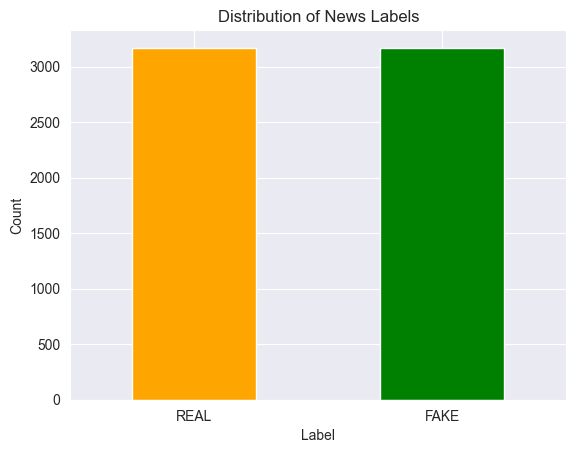

In [41]:
import matplotlib.pyplot as plt

data['label'].value_counts().plot(kind='bar', color=['orange', 'green'])
plt.title('Distribution of News Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()


### Checking Text Lengths and Nulls

count      6335.000000
mean       4773.528019
std        5091.586399
min          14.000000
25%        1804.500000
50%        3709.000000
75%        6254.500000
max      115448.000000
Name: content_length, dtype: float64


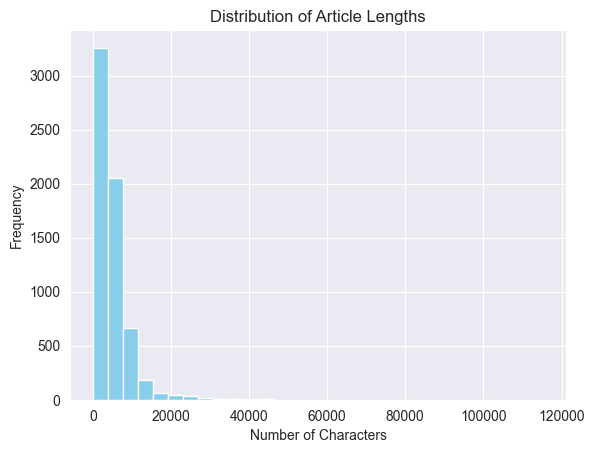

In [42]:
# Create a new column with combined title and text
data['content'] = data['title'].fillna('') + ' ' + data['text'].fillna('')

# Check content length
data['content_length'] = data['content'].apply(len)
print(data['content_length'].describe())

# Visualize text lengths
plt.hist(data['content_length'], bins=30, color='skyblue')
plt.title('Distribution of Article Lengths')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.show()


### Looking at Sample Articles

In [43]:
# Show a sample FAKE and REAL article
print("Sample FAKE News:\n", data[data['label'] == 'FAKE']['content'].iloc[0][:500])
print("\nSample REAL News:\n", data[data['label'] == 'REAL']['content'].iloc[0][:500])


Sample FAKE News:
 You Can Smell Hillary’s Fear Daniel Greenfield, a Shillman Journalism Fellow at the Freedom Center, is a New York writer focusing on radical Islam. 
In the final stretch of the election, Hillary Rodham Clinton has gone to war with the FBI. 
The word “unprecedented” has been thrown around so often this election that it ought to be retired. But it’s still unprecedented for the nominee of a major political party to go war with the FBI. 
But that’s exactly what Hillary and her people have done. Coma

Sample REAL News:
 Kerry to go to Paris in gesture of sympathy U.S. Secretary of State John F. Kerry said Monday that he will stop in Paris later this week, amid criticism that no top American officials attended Sunday’s unity march against terrorism.

Kerry said he expects to arrive in Paris Thursday evening, as he heads home after a week abroad. He said he will fly to France at the conclusion of a series of meetings scheduled for Thursday in Sofia, Bulgaria. He plans to me

## Text Preprocessing

### Combine Title and Article Text

In [44]:
data['content'] = data['title'].fillna('') + ' ' + data['text'].fillna('')

### Cleaning and Normalizing Text

In [45]:
import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)  # Remove non-alphabetical chars
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

data['content'] = data['content'].apply(clean_text)

### Train/Test Split

In [46]:
from sklearn.model_selection import train_test_split

X = data['content']  # using cleaned content
y = data['label'].map({'FAKE': 1, 'REAL': 0})  # Converting labels to numeric

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


 ### Vectorization with CountVectorizer

In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer
# TF-IDF Vectorization
vectorizer = TfidfVectorizer(
    stop_words='english',
    max_df=0.7,
    min_df=5,
    ngram_range=(1, 3),
)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

### Inspect Features

In [48]:
print(f"Vocabulary size: {len(vectorizer.get_feature_names_out())}")
print("Sample features:", vectorizer.get_feature_names_out()[:10])


Vocabulary size: 66078
Sample features: ['aa' 'aa superluminal' 'aa superluminal systems' 'aaron' 'abaaoud'
 'abaaouds' 'aback' 'abadi' 'abandon' 'abandoned']


### Output Matrix Shapes

In [49]:
print("X_train_tfidf shape:", X_train_tfidf.shape)
print("X_test_tfidf shape:", X_test_tfidf.shape)

X_train_tfidf shape: (5068, 66078)
X_test_tfidf shape: (1267, 66078)


## Modeling

### Model Selection: Linear Support Vector Classification

In [50]:
from sklearn.svm import LinearSVC

svc_model = LinearSVC(max_iter=2000, random_state=42)
svc_model.fit(X_train_tfidf, y_train)


LinearSVC(max_iter=2000, random_state=42)

### Making Predictions

In [51]:
y_pred = svc_model.predict(X_test_tfidf)

### Model Evaluation

In [55]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Detailed classification report
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=['REAL', 'FAKE']))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)


Accuracy: 0.9408
Classification Report:
               precision    recall  f1-score   support

        REAL       0.95      0.93      0.94       634
        FAKE       0.93      0.95      0.94       633

    accuracy                           0.94      1267
   macro avg       0.94      0.94      0.94      1267
weighted avg       0.94      0.94      0.94      1267

Confusion Matrix:
 [[588  46]
 [ 29 604]]


### Visualization of Confusion Matrix

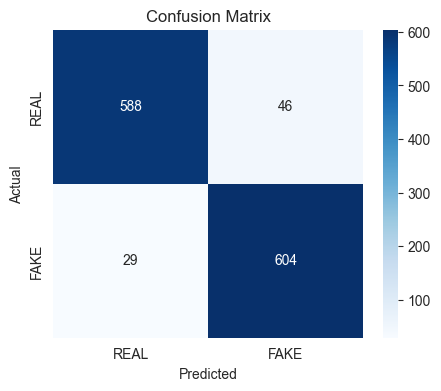

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['REAL', 'FAKE'], yticklabels=['REAL', 'FAKE'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


### Feature Importance of Top Predictive Words

In [54]:
import numpy as np

feature_names = vectorizer.get_feature_names_out()
coef = svc_model.coef_[0]

top_n = 15

# Top words for FAKE (positive coefficients)
top_fake_idx = np.argsort(coef)[-top_n:]
print("Top words for FAKE:")
print([feature_names[i] for i in top_fake_idx][::-1])

# Top words for REAL (negative coefficients)
top_real_idx = np.argsort(coef)[:top_n]
print("\nTop words for REAL:")
print([feature_names[i] for i in top_real_idx])


Top words for FAKE:
['october', 'november', 'hillary', 'article', 'election', 'share', 'source', 'establishment', 'oct', 'snip', 'mosul', 'podesta', 'hillary clinton', 'advertisement', 'print']

Top words for REAL:
['said', 'conservative', 'says', 'gop', 'candidates', 'sanders', 'cruz', 'marriage', 'convention', 'march', 'president', 'debate', 'tuesday', 'fox news', 'shooting']
